In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import cv2                                          #for img manipulation
import torch                                        #pytorch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import albumentations as A                          #for data augmentation
from torch.utils.data import Dataset, DataLoader    #for making a dataset
from pytorch_toolbelt.inference.tiles import ImageSlicer, TileMerger
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy
from sklearn.metrics import f1_score, accuracy_score #for score metric calcs


c:\Users\NSA\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = np.load('Data/test_once/test1_seismic.npy').transpose(2,1,0)
data.shape

(255, 701, 200)

In [3]:
print("xline: ", data.shape[1])
print('inline: ', data.shape[2])
print('sample: ', data.shape[0])
print('range amplitude: ', data.min(),'-',data.max())

xline:  701
inline:  200
sample:  255
range amplitude:  -1.0 - 1.0


In [4]:
test_data = data[:,:,0]

<function matplotlib.pyplot.show(close=None, block=None)>

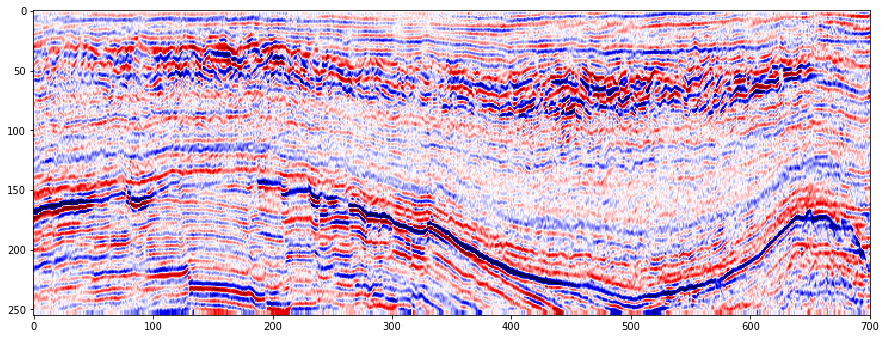

In [5]:
inline = 0
fig = plt.figure(figsize=(15,15))
plt.imshow(data[:,:,inline], cmap = 'seismic', interpolation= 'none')
plt.show

In [6]:
#train data
train_data = np.load('Data/train/train_seismic.npy').transpose(2,1,0)

<function matplotlib.pyplot.show(close=None, block=None)>

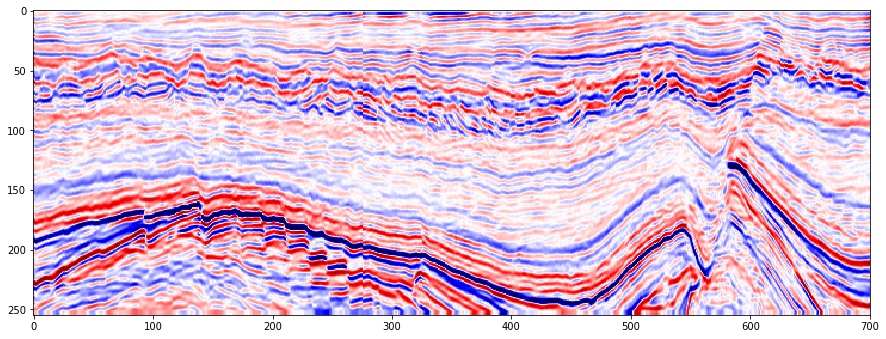

In [7]:
inline = 0
fig = plt.figure(figsize=(15,15))
plt.imshow(train_data[:,:,inline], cmap='seismic', interpolation='none')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

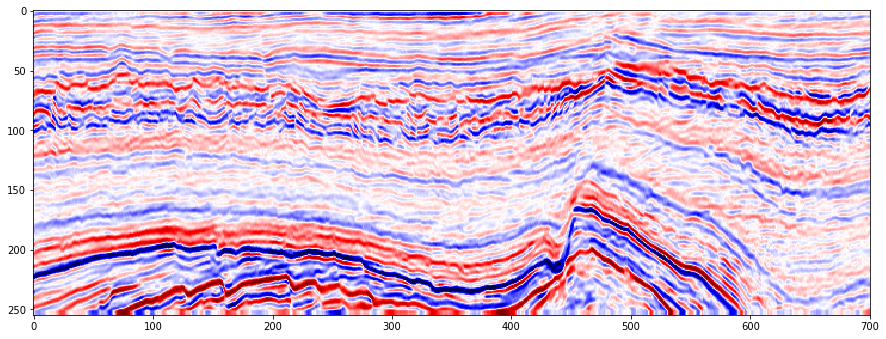

In [8]:
inline = 150
fig = plt.figure(figsize=(15,15))
plt.imshow(train_data[:,:,inline], cmap='seismic', interpolation='none')
plt.show

In [9]:
#to save the seismic xsection in order to manually add some faults
""" inline = 0
plt.imsave('SeisF3_%05d'%inline+'.png', train_data[:,:,inline], cmap='seismic')
inline = 150
plt.imsave('SeisF3_%05d'%inline+'.png', train_data[:,:,inline], cmap='seismic') """

" inline = 0\nplt.imsave('SeisF3_%05d'%inline+'.png', train_data[:,:,inline], cmap='seismic')\ninline = 150\nplt.imsave('SeisF3_%05d'%inline+'.png', train_data[:,:,inline], cmap='seismic') "

In [10]:
#training dataset
train_slice = train_data[:,:,0].copy()

In [11]:
train_label = cv2.imread('Data/SeisF3_00000_train_resized.jpg',0) #loading into numpy array
train_label = (np.round(1-train_label/255)).astype('int32')   #convert it into label binary format, 0 = no fault,  1 = fault   ; note: 255 is the image size height


<function matplotlib.pyplot.show(close=None, block=None)>

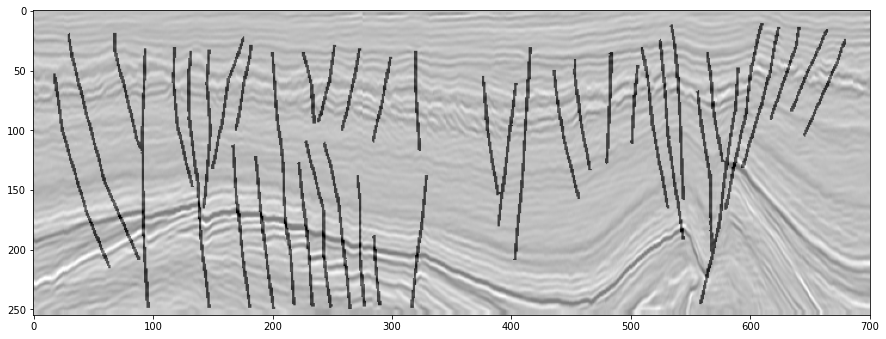

In [12]:
fig = plt.figure(figsize=(15,15))
plt.imshow(train_slice[:,:], cmap='gray')
plt.imshow(train_label[:,:], cmap='Greys', alpha=0.5)
plt.show

In [13]:
#now for inline 150
test_slice = train_data[:,:,150].copy()

In [14]:
test_label = cv2.imread('Data/SeisF3_000150_train_resized.jpg',0)
test_label = (np.round(1-test_label/255)).astype('int32')

<function matplotlib.pyplot.show(close=None, block=None)>

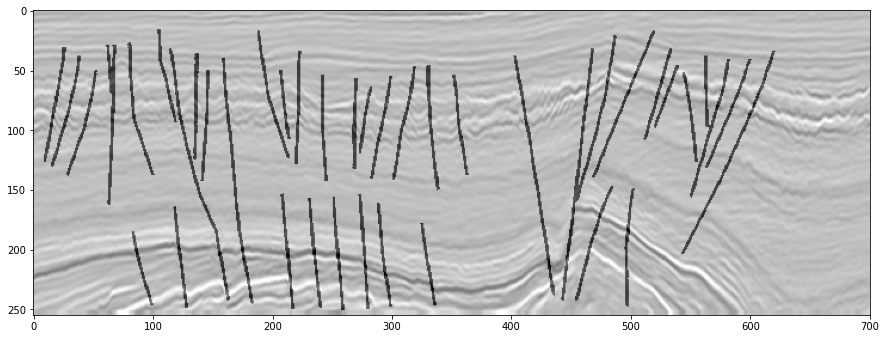

In [15]:
fig = plt.figure(figsize=(15,15))
plt.imshow(test_slice, cmap='gray')
plt.imshow(test_label, cmap='Greys', vmin=0, vmax=1, alpha=0.5)
plt.show

In [16]:
#dataset creation for augmentation - new data for the model to learn
class seisdataset_train(Dataset):
    def __init__(self, X, y, num_sample = 100):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        self.n_sample = num_sample
        self.aug = A.Compose([A.RandomCrop(p=1, height = 128, width=128),])

    def __len__(self):
        return self.n_sample

    def __getitem__(self,index):
        data = self.X
        label = self.y
        data_aug = self.aug(image=data, mask=label)
        data, label = data_aug['image'], data_aug['mask']
        return data[None,:,:], label


In [17]:
#test the dataset
train_data = seisdataset_train(train_slice, train_label, num_sample=50)

<function matplotlib.pyplot.show(close=None, block=None)>

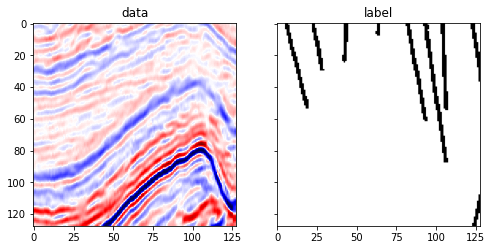

In [18]:
no_sample = 50
data_get = train_data[no_sample]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].imshow(data_get[0][0,:,:], cmap = 'seismic')
ax[1].imshow(data_get[1], cmap= 'Greys')
ax[0].set_title('data')
ax[1].set_title('label')
plt.show

In [19]:
#patching the test slice and making the dataset class
ps = 128 #patch size
lx = int(np.ceil(test_slice.shape[0]/ps)*np.ceil(test_slice.shape[1]/ps))
data_test_p = np.zeros([ps,ps,lx], dtype = 'float32')
label_test_p = np.zeros([ps,ps,lx], dtype = 'float32')


In [20]:
xx=0
for i in range(int(np.ceil(test_slice.shape[0]/ps))):
    for j in range(int(np.ceil(test_slice.shape[1]/ps))):
        if i==int(np.ceil(test_slice.shape[0]/ps))-1 and j==int(np.ceil(test_slice.shape[1]/ps))-1:
            data_test_p[:,:,xx] = test_slice[test_slice.shape[0]-ps:,test_slice.shape[1]-ps:]
            label_test_p[:,:,xx] = test_label[test_slice.shape[0]-ps:,test_slice.shape[1]-ps:]
        elif i==int(np.ceil(test_slice.shape[0]/ps))-1:
            data_test_p[:,:,xx] = test_slice[test_slice.shape[0]-ps:,j*ps:j*ps+ps]
            label_test_p[:,:,xx] = test_label[test_slice.shape[0]-ps:,j*ps:j*ps+ps]
        elif j==int(np.ceil(test_slice.shape[1]/ps))-1: 
            data_test_p[:,:,xx] = test_slice[i*ps:i*ps+ps,test_slice.shape[1]-ps:]
            label_test_p[:,:,xx] = test_label[i*ps:i*ps+ps,test_slice.shape[1]-ps:]
        else:
            data_test_p[:,:,xx] = test_slice[i*ps:i*ps+ps,j*ps:j*ps+ps]
            label_test_p[:,:,xx] = test_label[i*ps:i*ps+ps,j*ps:j*ps+ps]
        xx=xx+1
data_test_p.shape

(128, 128, 12)

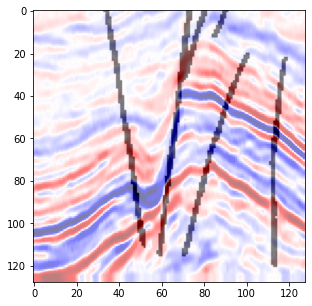

In [21]:
inline =9
fig = plt.figure(figsize=(5,5))
plt.imshow(data_test_p[:,:,inline], cmap = 'seismic')
plt.imshow(label_test_p[:,:,inline], cmap = 'Greys', vmin=0, vmax=1, alpha=0.5)
plt.show()

In [22]:
#dataset creation for augmentation - new data for the model to test
class seisdataset_test(Dataset):
    def __init__(self, X, y, training = True):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        
    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        return data[None,:,:], label


In [23]:
# Training parameters
batch_size = 8
num_epochs = 50          # represents how many times the model is learning
num_classes = 2         # binary classification, fault or no fault.
learning_rate = 0.001   # number to be optimized. > Learning Rate > faster coverage < global optimum


In [24]:
# getting the dataset into loader
def get_data_loaders(batch_size):
    train_data = seisdataset_train(train_slice, train_label, num_sample=150)
    test_data = seisdataset_test(data_test_p, label_test_p)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, drop_last = True)
    test_loader = DataLoader(dataset = test_data, batch_size=12, shuffle=False, drop_last=True)
    return train_loader, test_loader

In [25]:
""" device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') """
train_loader,test_loader = get_data_loaders(batch_size)


In [26]:
# defining Unet
#source:    https://github.com/milesial/Pytorch-UNet/
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    #"""(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    #Downscaling with maxpool then double conv

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    #"Upscaling then double conv"

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)     



In [27]:
num_classes=2


In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=num_classes).to(device)
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [29]:
# time to choose loss function and optimization algorithm
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [30]:
#empty varialbes to put the metrics
train_losses = []
valid_losses =[]
train_F1 = []
test_F1 = []
train_acc =[]
test_acc = []
F1_old = 0.0

In [31]:
#Time to retrain the model
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    acc_test = 0.0    
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        #print(label.shape)
        #print(pred.shape)
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc

    model.eval()
    for data, label in test_loader:
        
        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)     

        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        acc_test += acc




    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size    
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)      

    if F1_old < F1_test:
      F1_old = F1_test
      torch.save(model.state_dict(), 'model_retrain.ckpt')

    # print
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tF1_train: {:.6f} \tF1_test: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test))

        


Epoch: 1 	Training Loss: 0.443324 	Validation Loss: 2.975657 	F1_train: 0.050151 	F1_test: 0.003393
Epoch: 2 	Training Loss: 0.318901 	Validation Loss: 2.006612 	F1_train: 0.000801 	F1_test: 0.004066
Epoch: 3 	Training Loss: 0.302135 	Validation Loss: 2.097720 	F1_train: 0.001025 	F1_test: 0.000000
Epoch: 4 	Training Loss: 0.279160 	Validation Loss: 1.923277 	F1_train: 0.005108 	F1_test: 0.000000
Epoch: 5 	Training Loss: 0.249193 	Validation Loss: 2.043070 	F1_train: 0.053543 	F1_test: 0.003067
Epoch: 6 	Training Loss: 0.230632 	Validation Loss: 1.964430 	F1_train: 0.253971 	F1_test: 0.032224
Epoch: 7 	Training Loss: 0.196928 	Validation Loss: 2.107075 	F1_train: 0.475667 	F1_test: 0.050048
Epoch: 8 	Training Loss: 0.152253 	Validation Loss: 2.134229 	F1_train: 0.628690 	F1_test: 0.080565
Epoch: 9 	Training Loss: 0.119874 	Validation Loss: 2.291919 	F1_train: 0.710328 	F1_test: 0.088041
Epoch: 10 	Training Loss: 0.096770 	Validation Loss: 2.496800 	F1_train: 0.774048 	F1_test: 0.091532

KeyboardInterrupt: 

In [33]:
#Loading the results
model.load_state_dict(torch.load('model_retrain.ckpt'))

<All keys matched successfully>

In [34]:
print('best F1_test: ', F1_old)

best F1_test:  0.09156895589056392


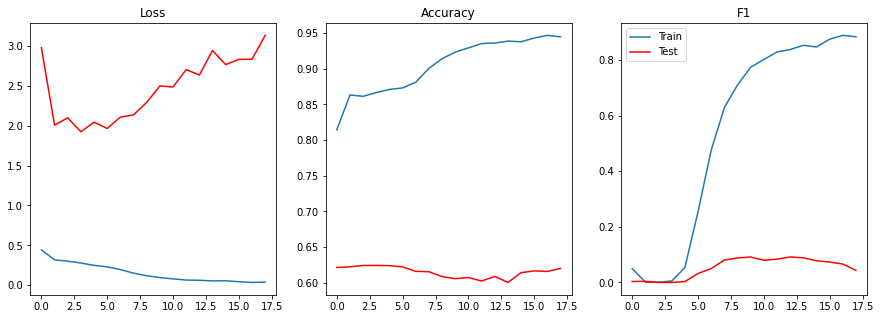

In [35]:
fig2, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(train_losses)
ax[0].plot(valid_losses, '-r')
ax[0].set_title('Loss')

ax[1].plot(train_acc)
ax[1].plot(test_acc, '-r')
ax[1].set_title('Accuracy')

ax[2].plot(train_F1)
ax[2].plot(test_F1, '-r')
ax[2].set_title('F1')
ax[2].legend(('Train', 'Test'))
plt.show()




In [36]:
#Plotting the results

inline = 1

data2 = np.load('Data/test_once/test1_seismic.npy').transpose(2,1,0)       #not sure why I needed to re import the data.. put it as 'data2' instead of 'data' this time

img = data2[:,:,inline].astype('float32')
model.eval()

tiler = ImageSlicer(img.shape, tile_size = (128,128), tile_step = (64,64))
merger = TileMerger(tiler.target_shape, 1, tiler.weight)

tiles = [tile for tile in tiler.split(img[:, :, None])]

for tiles_batch, coords_batch in DataLoader(list(zip(tiles, tiler.crops)), batch_size=1):
    tiles_batch = tiles_batch.permute(0, 3, 1, 2)
    output=model(tiles_batch.to(device))
    pred_batch=output.data.max(1)[1]
    merger.integrate_batch(pred_batch, coords_batch)
merged_mask = np.moveaxis(to_numpy(merger.merge()), 0, -1).astype(np.uint8)
merged_mask = tiler.crop_to_orignal_size(merged_mask)
merged_mask=merged_mask[:,:,0]

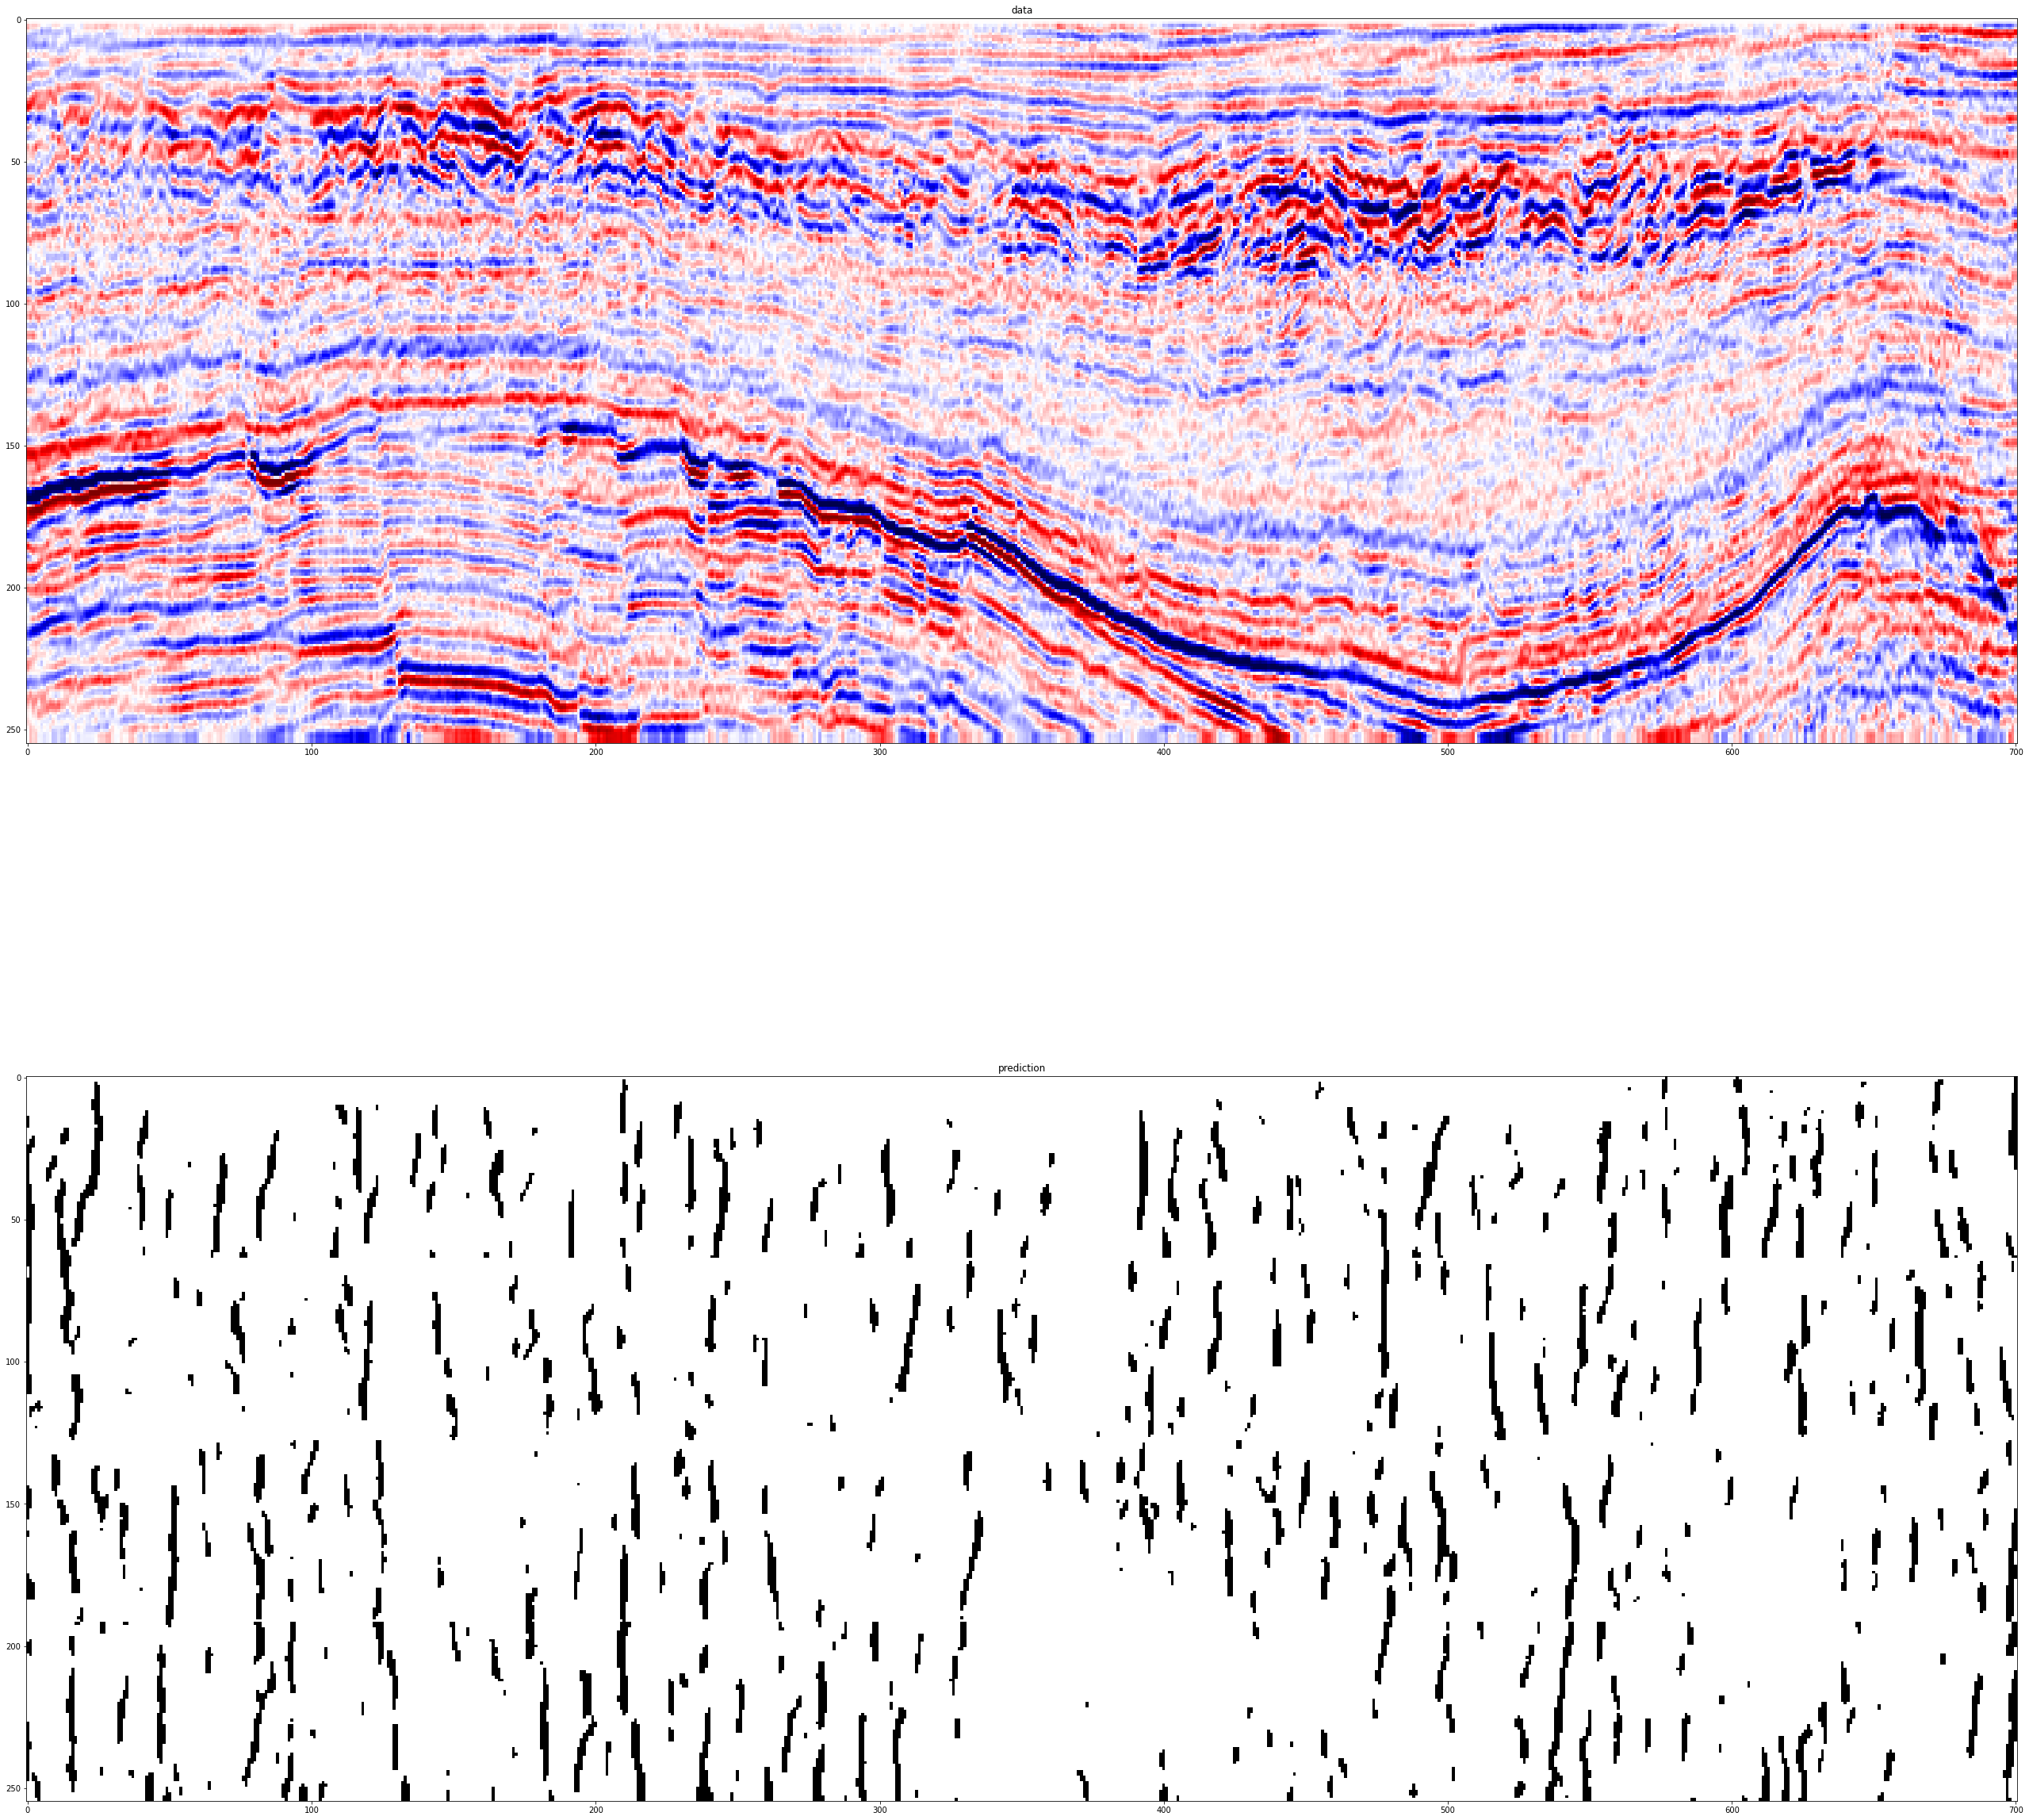

In [37]:
fig, ax = plt.subplots(2,1, sharey=True, figsize=(45,45))
ax[0].imshow(img, cmap='seismic')
ax[1].imshow(merged_mask, cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('prediction')
plt.show()



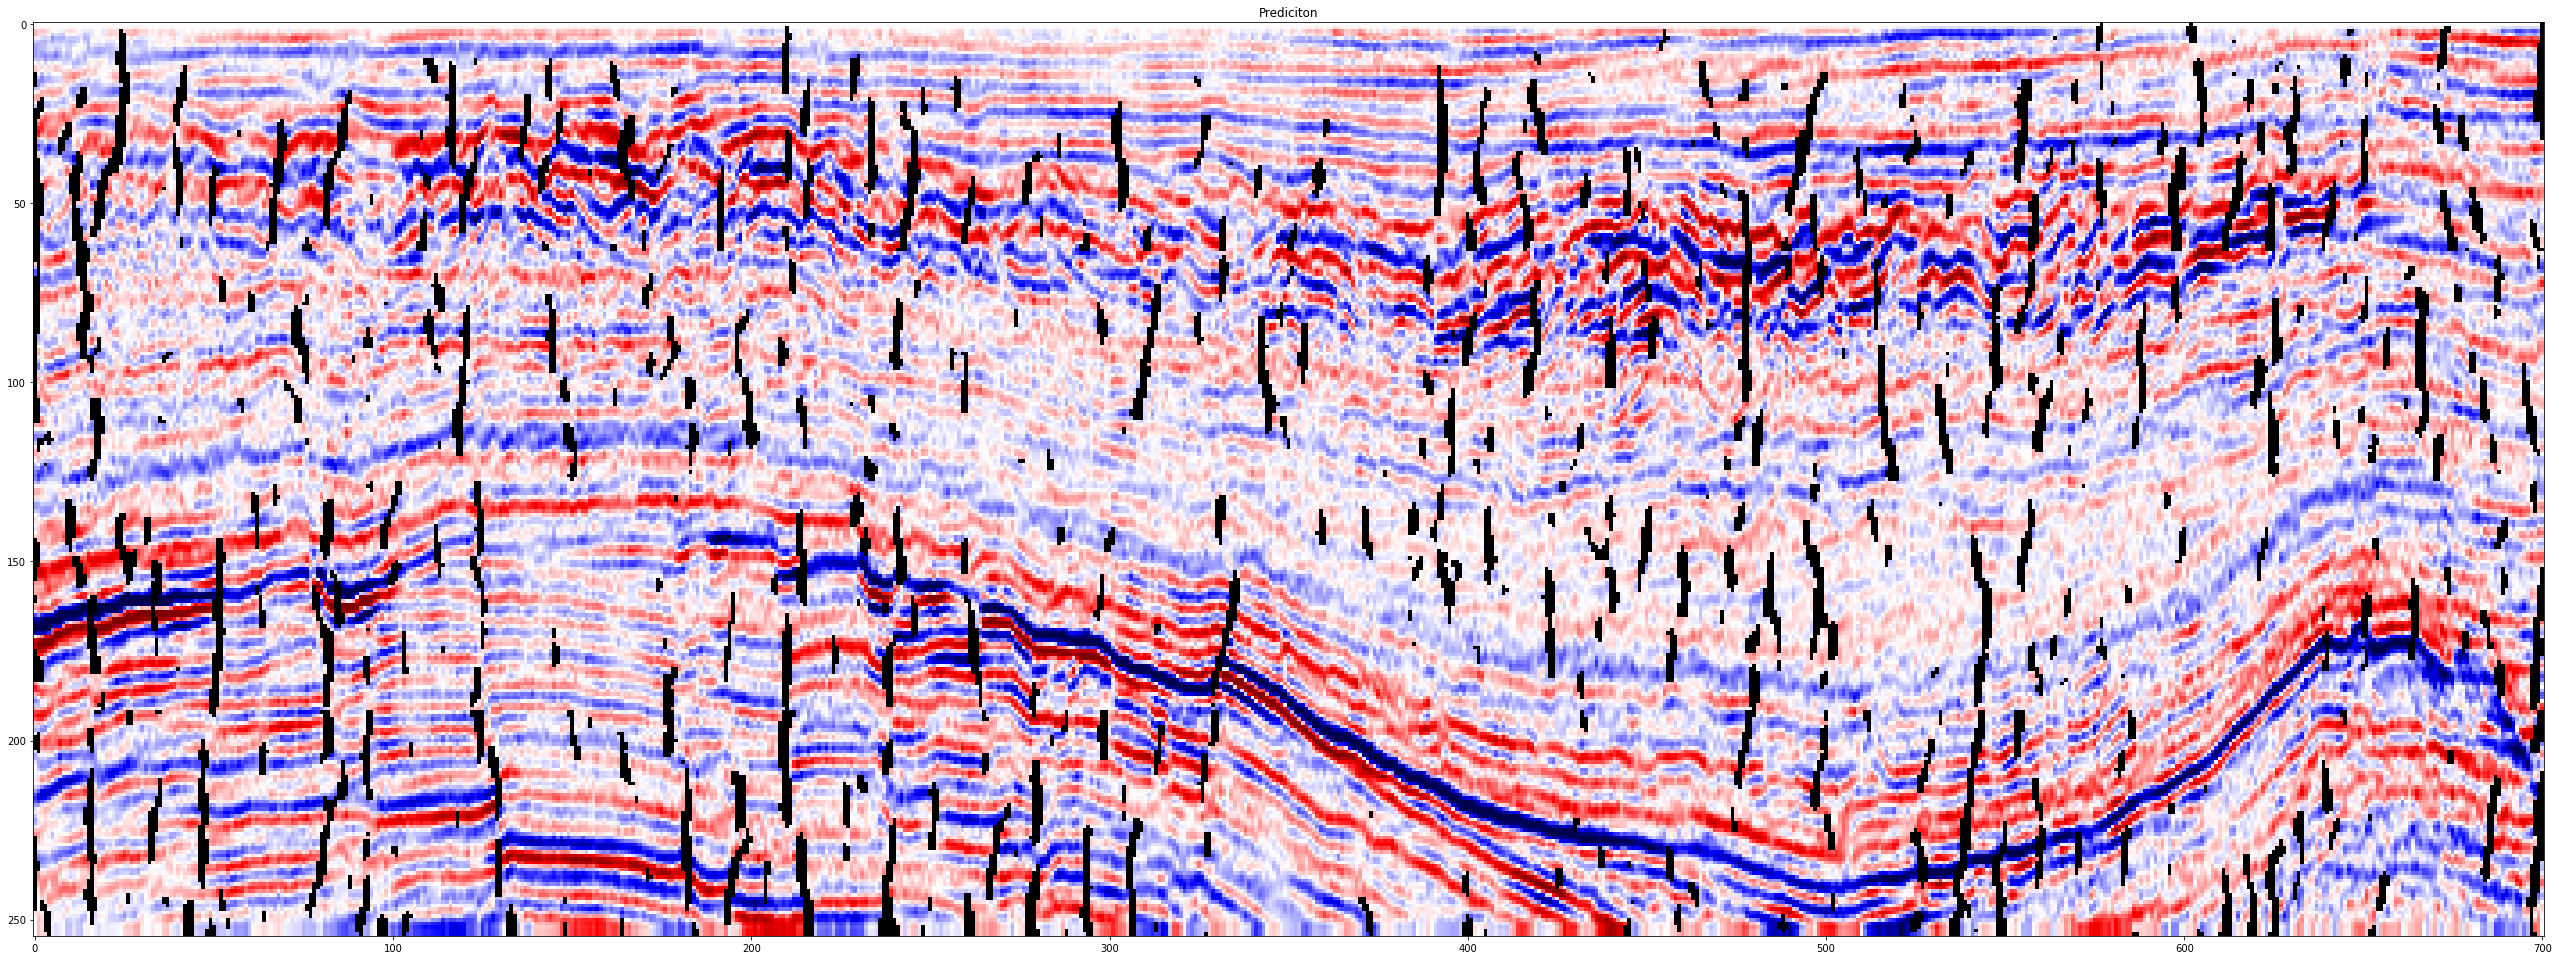

In [38]:
mask_label = merged_mask.copy()
mask_label = np.zeros(merged_mask.shape + (4,))
mask_label[:,:,3] = merged_mask

fig = plt.figure(figsize=(45,45))
plt.imshow(img, cmap='seismic')
plt.imshow(mask_label)
plt.title('Prediciton')
plt.show()

In [41]:
from mayavi import mlab

source = mlab.pipeline.scalar_field(data2)
source.spacing = [1, 1, -1]

for axis in ['x', 'z']:
    plane = mlab.pipeline.image_plane_widget(source, 
                                    plane_orientation='{}_axes'.format(axis),
                                    slice_index=100, colormap='gray')
    # Flip colormap. Better way to do this?
    plane.module_manager.scalar_lut_manager.reverse_lut = True

mlab.outline()
mlab.show()
